# Postprocessing optimization

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
from functools import partial

import numpy as np
import pandas as pd
from xgboost import XGBClassifier

from vassi.classification.predict import k_fold_predict
from vassi.classification.visualization import plot_classification_timeline
from vassi.classification.postprocessing import (
    optimize_postprocessing_parameters,
    summarize_experiment,
)
from vassi.config import cfg
from vassi.features import DataFrameFeatureExtractor
from vassi.io import load_dataset, from_yaml
from vassi.logging import set_logging_level
from vassi.utils import Experiment

First, import additional helper functions from `helpers.py`.

In [3]:
from helpers import (
    postprocessing,
    smooth_model_outputs,
    subsample_train,
    suggest_postprocessing_parameters,
)

Next, define the configuration used for the trajectories. We need to define how the keypoints and timestamps were called (`'keypoints'` and `'timestamps'`, see `case_studies.calms21.convert` module for details). Those two are the sole data series that each trajectory consists of.

In [4]:
cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"
cfg.trajectory_keys = ("keypoints", "timestamps")

Now, the training dataset can be loaded, we specify the behavioral category `'none'` (renamed from *other* in the CALMS21 dataset) as `background_category`. The target of this dataset is `'dyad'`, i.e., we want to classify dyadic behavioral interactions between two individuals. 

However, we exclude all dyads in which the intruder mouse is the actor. All behavioral annotations in the CALMS21 dataset focus on the behavior of the resident mouse.

In [5]:
dataset_train = load_dataset(
    "mice_train",
    directory="../../datasets/CALMS21/train",
    target="dyad",
    background_category="none",
)

dataset_train = dataset_train.exclude_individuals(["intruder"])

2025-06-17 16:08:27.252 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


Then, initialize a `FeatureExtractor`, here a `DataFrameFeatureExtractor`, that extracts spatiotemporal features from pairwise trajectories.

We load the configuration as specified in `config_file.yaml` which extracts a total of 201 features.

In [6]:
extractor = DataFrameFeatureExtractor(
    cache_directory="feature_cache_mice",
    cache_mode="cached",
).read_yaml(
    "features-mice.yaml"
)

len(extractor.feature_names)

201

The following cell is equivalent to the `scripts/postprocessing_experiment-mice.py` script, which uses a `DistributedExperiment` for MPI parallelization to perform all 20 runs in parallel. Instead, we here use a sequential `Experiment` without parallelization to ensure deterministic results.

This may take a long time to finish (approx. one day). We use optuna (https://optuna.org/), a framework for automated hyperparameter search to find optimal parameters for the postprocessing of classification results. `optuna` implements algorithms to find these optimal parameters efficiently, but we do not run these searches (https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html) with parallelization for deterministic results.

In one `Experiment`, `num_runs` (here 20) are performed. The following steps are executed to find optimal postprocessing hyperparameters in each run:

- use `k_fold_predict` to fit `k` independent classifiers (specified with the `classifier` argument) and use them to predict on the entire training dataset (specified with the `dataset` argument).
  - internally, the `sampling_function` (see `subsample_train` from `helpers.py`) is used to extract samples with a `DataFrameFeatureExtractor`, resulting in a feature table with corresponding target categories for each dataset fold.
  - these are then used to fit the classifiers (with balanced sample weights with `balance_sample_weights=True`)
- the predictions are then used to measure hyperparameter scores. The function `suggest_postprocessing_parameters` defines the search space that `optuna` will consider when optimizing the specified parameters. Each `optuna.study.Study` performs `num_trials` (here, 2000), reporting the best parameters that yielded the highest score across all trials. See the few last cells in this notebook for details on this score.

- finally, the function `summarize_experiment` is used to analyze and save the results of all runs, and determine the best parameters (as a consensus across runs; for each parameter, we find the value in its respective search space with highest density of best values). Averaging, for example, would be problematic when the resulting distribution of best parameters is bimodal.

In [7]:
run_locally = False

if run_locally:
    log = set_logging_level("info")
    studies = optimize_postprocessing_parameters(
        dataset_train,
        extractor,
        XGBClassifier(n_estimators=1000),
        postprocessing_function=postprocessing,
        suggest_postprocessing_parameters_function=suggest_postprocessing_parameters,
        num_trials=2000,
        k=5,
        sampling_function=subsample_train,
        balance_sample_weights=True,
        experiment=Experiment(20, random_state=1),
        log=log,
    )
    best_parameters = summarize_experiment(studies, log=log)

Instead, only load the best parameters that were written to `optimization-summary.yaml`.

In [8]:
best_parameters = from_yaml("optimization-summary.yaml")
best_thresholds = [best_parameters[f"threshold-{category}"] for category in dataset_train.categories]

print(f"Best thresholds:\n\n{best_thresholds}\n")
print(f"Best paramaters (including thresholds):\n\n{pd.Series(best_parameters)}")

Best thresholds:

[0.48207882111726374, 0.05732442454560765, 0.50951643728907, 0.5710688839382034]

Best paramaters (including thresholds):

smoothing_function                               mean
quantile_range_window_lower-attack                 91
quantile_range_lower-attack                  0.446991
quantile_range_window_upper-attack                 85
quantile_range_upper-attack                  0.972923
smoothing_window-attack                            91
quantile_range_window_lower-investigation          49
quantile_range_lower-investigation           0.026315
quantile_range_window_upper-investigation          71
quantile_range_upper-investigation           0.900383
smoothing_window-investigation                     73
quantile_range_window_lower-mount                  59
quantile_range_lower-mount                    0.19093
quantile_range_window_upper-mount                  73
quantile_range_upper-mount                   0.751628
smoothing_window-mount                           

Now, we use k-fold to predict on the entire training dataset, fitting a separate classifier on each dataset fold (k=5). These classifiers are then used to predict on their fold's respective holdout data.

In [9]:
from helpers import *

In [10]:
k_fold_result = k_fold_predict(
    dataset_train,
    extractor,
    XGBClassifier(n_estimators=1000),
    k=5,
    sampling_function=subsample_train,
    balance_sample_weights=True,
    log=set_logging_level("success"),
)

/home/paul/miniforge3/envs/vassi/lib/python3.13/site-packages/sklearn/model_selection/_split.py:784: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_of_target_y = type_of_target(y)


2025-06-17 16:08:29.582 [SUCCESS ] [fold: 0/5] finished sampling in 1.46 seconds
2025-06-17 16:10:23.323 [SUCCESS ] [fold: 0/5] finished fitting XGBClassifier in 113.72 seconds
2025-06-17 16:10:28.018 [SUCCESS ] [fold: 0/5] finished predicting on dataset in 4.69 seconds
2025-06-17 16:10:29.498 [SUCCESS ] [fold: 1/5] finished sampling in 1.44 seconds
2025-06-17 16:12:19.270 [SUCCESS ] [fold: 1/5] finished fitting XGBClassifier in 109.74 seconds
2025-06-17 16:12:26.479 [SUCCESS ] [fold: 1/5] finished predicting on dataset in 7.21 seconds
2025-06-17 16:12:27.947 [SUCCESS ] [fold: 2/5] finished sampling in 1.42 seconds
2025-06-17 16:14:17.485 [SUCCESS ] [fold: 2/5] finished fitting XGBClassifier in 109.50 seconds
2025-06-17 16:14:24.063 [SUCCESS ] [fold: 2/5] finished predicting on dataset in 6.58 seconds
2025-06-17 16:14:25.582 [SUCCESS ] [fold: 3/5] finished sampling in 1.47 seconds
2025-06-17 16:16:14.526 [SUCCESS ] [fold: 3/5] finished fitting XGBClassifier in 108.91 seconds
2025-06-17

With this, we can calculate per-category f1 scores on three levels:

1. *timestamp* (i.e., video frames)
2. *annotation* (ground-truth, annotated intervals)
3. *prediction* (predicted intervals)

In the optimization above, `optuna` used the unweighted avarage of these three scores (and across all categories) to determine the best parameters.

For levels 2 and 3 (interval-based scores), the corresponding true or predicted labels are chosen
from the interval with the longest overlap duration.

Thresholding sets the model outputs (probabilities) below the specified threshold for each category to 0. Subsequently, the category with the highest probability is selected, otherwise, if all categories were below their threshold, falling back to the `default_decision` (which is usually the background category, here `'none'`).

In [11]:
from interactive_table import Table

In [12]:
scores = postprocessing(
    k_fold_result,
    postprocessing_parameters=best_parameters,
    decision_thresholds=best_thresholds,
    default_decision="none",
).score()

Table(scores)

Table(children=[_TableDisplay(events=['action_click', 'apply_filters', 'on_edit_close', 'on_edit_submit', 'tog…

The cell above is using the predefined `postprocessing` function from `helpers.py`, which is equivalent to the following code (step-by-step):

- use `functools.partial` to bind the best postprocessing parameters to their corresponding, predefined smoothing function `smooth_model_outputs` (also from `helpers.py`). This is similar to using a `lambda` function, but can be used with multiprocessing.
- use the `result.smooth` method with the resulting function to apply smoothing with the optimal parameters.
- use the `result.threshold` method with the optimal decision thresholds. Make sure to define the default decision (here, the background category 'none').

In [13]:
optimized_model_output_smoothing = partial(smooth_model_outputs, best_parameters)

k_fold_result = k_fold_result.smooth(optimized_model_output_smoothing)
k_fold_result = k_fold_result.threshold(best_thresholds, default_decision="none")

Table(k_fold_result.predictions)

Table(children=[_TableDisplay(events=['action_click', 'apply_filters', 'on_edit_close', 'on_edit_submit', 'tog…

Finally, these predictions can be visualized, for example in a behavioral timeline (gantt-plot) below.

Here, we select the first sequence in the training dataset (`0`). Note that each sequence is a group with a single, directed dyad: `("resident", "intruder")`.

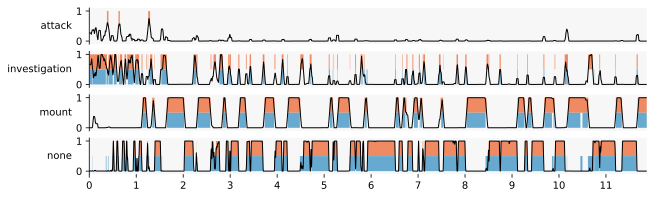

In [14]:
dyad_results = k_fold_result.classification_results[0].classification_results[
    ("resident", "intruder")
]

plot_classification_timeline(
    dyad_results.predictions,
    dyad_results.categories,
    annotations=dyad_results.annotations,
    timestamps=dyad_results.timestamps,
    interval=(-np.inf, np.inf),
    y_proba_smoothed=dyad_results.y_proba_smoothed,
    x_tick_step=(60 * 30),
    x_tick_conversion=lambda ticks: [int(tick / (30 * 60)) for tick in ticks],
)